# Sample size determination in Python

The purpose of this exercise is to calculate how many people need to be shown the new assets before we can check if the results are a significant improvement.

Nosh Mish Mosh wants to run an experiment to see if we can convince more people to purchase meal plans if we use a more artisanal-looking vegetable selection. We’ve photographed these modern meals with blush tomatoes and graffiti eggplants, but aren’t sure if this strategy will sell enough units to benefit from establishing a business relationship with a new provider.

Before running this experiment, of course, we need to know how many people have to see the new assets. We don’t want customers seeing food that we won’t end up offering. Of course, there are three things we need to know before we determine that number.

### The basics in sample size determination for A/B Tests
- Baseline conversion rate: the approximate percent of the population that satisfies the hypothesis.
- Statistical significance: the probability of the study rejecting the null hypothesis, given that the null hypothesis was assumed to be true.
- Minimum detectable effect: the lift is the minimum difference between the A and B samples we want to be able to detect.
- The confident level: How confident we need to be.

In [1]:
# Libraries
import noshmishmosh
import pandas as pd
import numpy as np
from scipy import stats
import math
import seaborn as sns
from matplotlib import pyplot

# Functions
def tolist(tag):
    out = [i[tag] for i in visits]
    return out

### 00. Generating the dataframe

In [2]:
visits = noshmishmosh.customer_visits

df_visits = pd.DataFrame({'ids': tolist('id'),
              'name': tolist('name'),
              'clickedthrough': tolist('clickedthrough'),
              'purchased': tolist('purchased'),
              'moneyspent': tolist('moneyspent')
             })


print(df_visits.head())

     ids            name  clickedthrough  purchased  moneyspent
0  83421    Michael Todd            True      False         0.0
1  46042  Brianna Harmon            True      False         0.0
2  23766    Mario Arnold           False      False         0.0
3  20859      Paul Quinn           False      False         0.0
4  57771    Jerome Moore            True      False         0.0


### 01. Calculating the baseline

In [3]:
paying_visitors = df_visits[df_visits.purchased == True].ids.count()
print('Number of visitors that purchased: {}'.format(paying_visitors))

total_visitors = df_visits.ids.count()
print('Number of total visitors: {}'.format(total_visitors))

baseline = paying_visitors/total_visitors
print('The baseline is: {} %'.format(baseline*100))

Number of visitors that purchased: 93
Number of total visitors: 500
The baseline is: 18.6 %


### 02. Minimum Detectable Effect
We’d like to know for sure that we’ll be pulling in at least $1240 more every week. In order to figure out how many more customers we need. We’ll have to investigate the average revenue generated from a given sale. 

In [4]:
revenue = 1240

payments = noshmishmosh.money_spent
print('These are the first 5 payments sample: {}'.format(payments[:5]))

mean_payments = round(np.mean(payments))
print('The average payment is: {} $'.format(mean_payments))

n_payments = np.ceil(revenue/mean_payments)
print('We need {} payments to pull in the revenue'.format(int(n_payments)))

These are the first 5 payments sample: [39.01, 10.16, 36.88, 23.41, 33.49]
The average payment is: 27.0 $
We need 46 payments to pull in the revenue


### 03. Calculating the lift percentage

Now find the percent lift required. What percentage increase is needed to pull in the revenue?

In [5]:
lift = n_payments/total_visitors
print('The lift required is: {}%'.format(lift*100))

The lift required is: 9.2%



In order to find our minimum detectable effect, we need to express percentage_point_increase as a percent of baseline_percent.

In [6]:
minimum_detectable_effect = np.ceil(lift/baseline)
print('The minimum detectable effect is: {}'.format(minimum_detectable_effect))

The minimum detectable effect is: 1.0


### 04. Overview of the two proportion Z test
The two-sample Z test for proportions determines whether a population proportion p1 is equal to another population proportion p2. In our example, p1 and p2 are the proportion of visitors before and after the marketing change, and we want to see whether there was a statistically significant increase in p2 over p1.

\begin{equation}
Z = \frac{P2-P1}{\sqrt {P*(1-p*)(\frac{1}{n} + \frac{1}{n})}}
\end{equation}


\begin{equation}
p* = \frac{n1p1 + n2p2}{n1 + n2}
\end{equation}

Where p* is the proportion of 'successes'. In this example the number of paying visitors.

Ultimately, we want to make sure we’re able to calculate a difference between p1 and p2 when it exists. So, let’s assume you know that the “true” difference that exists between p1 and p2. Then, we can look at sample size requirements for various confidence levels and absolute levels of p1.

We need a way of figuring out Z, so we can determine whether a given sample size provides statistically significant results, so let’s define a function that returns the Z value given p1, p2, n1, and n2.

In [7]:
# Test that both populations have the same proportion.
def z_calc(p1, p2, n1, n2):
    p_star = (p1*n1 + p2*n2) / (n1 + n2)
    return (p2 - p1) / math.sqrt(p_star*(1 - p_star)*((1.0 / n1) + (1.0 / n2)))

Then, we can define a function that returns the sample required, given p1 (the before probability), p_diff (i.e. p2-p1), and alpha (which represents the p-value, or 1 minus the confidence level). For simplicity, we’ll just assume that n1 = n2. If you know in advance that n1 will have about a quarter of the size of n2, then it’s trivial to incorporate this into the function. However, you typically don’t know this in advance and in our scenario an equal sample assumption seems reasonable.

The function is fairly simplistic: it counts up from n starting from 1, until n gets large enough where the probability of that statistic being that large (i.e. the p-value) is less than alpha (in this case, we would reject the null hypothesis that p1 = p2). The function uses the normal distribution available from the scipy library to calculate the p-value and compare it to alpha.

In [8]:
# Sample calculator
def sample_required(p1, p_diff, alpha):
    n = 1
    while True:
        z = z_calc(p1, p1+p_diff, n1=n, n2=n)
        p = 1 - stats.norm.cdf(z)
        if p < alpha:
            break
        n += 1
    return n

### 04. Calculating the sample size
These functions we’ve defined provide the main tools we need to determine the minimum sample levels required. In this example, we want to calculate a 9.2% difference with a 95% confidence level, with a p1 as a baseline of 18.6%. We can calculate our Sample Size needed in this case and plot all the sample sizes depending on the baseline or the initial probability.

In [18]:
sample_size = sample_required(baseline, lift, .05)
print('The final sample size is calculated with a baseline of {}% and a lift of {}%.'.format(baseline*100, lift*100), '\n')
print('For this example Nosh Mish Mosh needs to show the new pictures to {} people to make sure there is any improvement'.format(sample_size))

The final sample size is calculated with a baseline of 18.6% and a lift of 9.2%. 

For this example Nosh Mish Mosh needs to show the new pictures to 114 people to make sure there is any improvement


### 05. Ploting the minimum sample size needed by the initial probability

In [10]:
baseline_range = [i*.01 for i in range(96)]

data = []
for bsl in baseline_range:
    record = {}
    record['Probability Difference'] = lift
    record['Sample Size to Detect Difference'] = sample_required(p1=bsl,
                                                                p_diff=lift,
                                                                alpha=.05)
    record['Confidence Level'] = '95%'
    record['Initial Probability'] = bsl * 100
    data.append(record)

df = pd.DataFrame(data)
print(df.head())

   Probability Difference  Sample Size to Detect Difference Confidence Level  \
0                   0.092                                29              95%   
1                   0.092                                34              95%   
2                   0.092                                40              95%   
3                   0.092                                45              95%   
4                   0.092                                51              95%   

   Initial Probability  
0                  0.0  
1                  1.0  
2                  2.0  
3                  3.0  
4                  4.0  


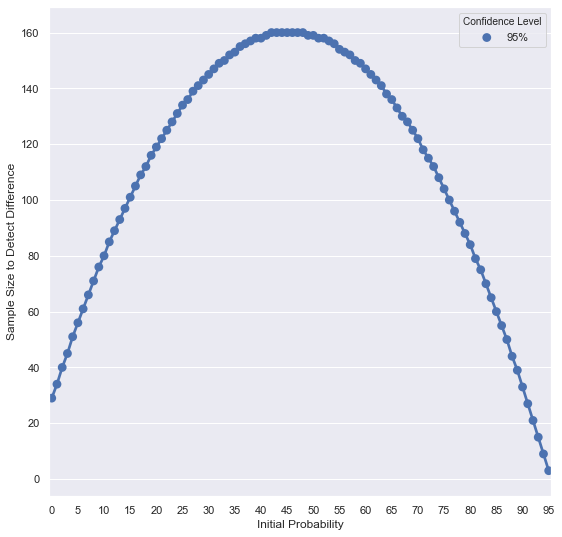

In [23]:
fig, ax = pyplot.subplots(figsize=(9, 9))
sns.set(style='darkgrid')

plot = sns.pointplot(x='Initial Probability',
            y='Sample Size to Detect Difference',
            hue='Confidence Level', ax = ax,
            data=df)

labels = []
for i in range(0, 101):
    if i % 5 == 0:
        labels.append(str(i))
    else:
        labels.append('')
plot.set_xticklabels(labels=labels);

As we see in the figure, the highest sample size occurs when the initial probability or the baseline is close to 50% of the population (P1). This means that is harder to detect a difference when the population baseline is a homogeneous mixture.

### 06. Ploting the minimum sample size required by the lift expected

In [30]:
print(baseline*100)
lift_range = range(5, 80)


samples_lift = [sample_required(baseline, lift/100, .05) for lift in lift_range]
dic = {'Lift': lift_range, 'Sample required': samples_lift, 'Confidence Level': '95%'} 
    
df = pd.DataFrame(dic)
print(df)

18.6
    Lift  Sample required Confidence Level
0      5              361              95%
1      6              255              95%
2      7              191              95%
3      8              148              95%
4      9              119              95%
..   ...              ...              ...
70    75                3              95%
71    76                3              95%
72    77                3              95%
73    78                3              95%
74    79                3              95%

[75 rows x 3 columns]


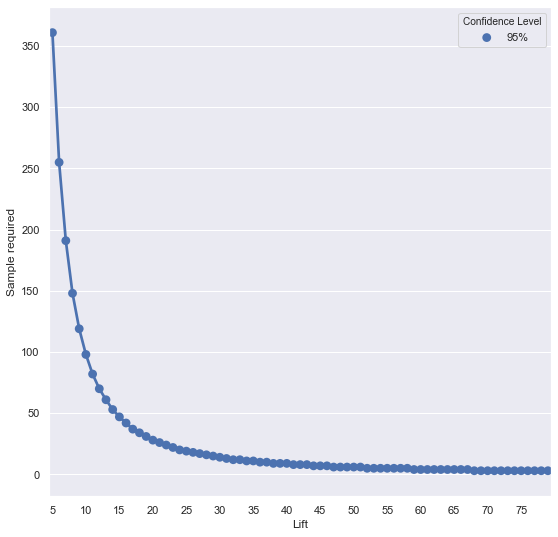

In [33]:
fig, ax = pyplot.subplots(figsize=(9, 9))
sns.set(style='darkgrid')

plot = sns.pointplot(x='Lift',
            y='Sample required',
            hue='Confidence Level', ax = ax,
            data=df)

labels = []
for i in range(5, 101):
    if i % 5 == 0:
        labels.append(str(i))
    else:
        labels.append('')
plot.set_xticklabels(labels=labels);

As we see in this figure, we need an exponentially bigger sample size if we want to be able to detect smaller lifts, while we are able to detect easily bigger lifts with a smaller sample size.

### Conclusion
The example shows how Python can be a very useful tool for performing “back of the envelope” calculations, such as estimates of required sample sizes for tests where this determination is not straightforward. These calculations can save you a lot of time and money, especially when you’re thinking about collecting your own data for a research project.